In [119]:
import gym
import sys
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [120]:
env = gym.make('MountainCar-v0') #MsPacman-v0
env.seed(505);
# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)
print("Actions space:", env.action_space)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
State space: Box(2,)
- low: [-1.2  -0.07]
- high: [0.6  0.07]
Actions space: Discrete(3)


In [121]:
def create_uniform_grid(low, high, bins=(10, 10)):
    """Define a uniformly-spaced grid that can be used to discretize a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins along each corresponding dimension.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    return [np.linspace(low[i], high[i], num=(bins[i]+1))[1:-1] for i in range(len(low))]


In [122]:
def plot_q_table(q_table):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table, axis=2)       # max Q-value for each state
    q_actions = np.argmax(q_table, axis=2)  # best action for each state

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap='jet');
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x, y, q_actions[x, y], color='white',
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')


In [137]:
class GymAgent:

    def __init__(self, env, nA=9, state_grid=None, gamma=0.99, alpha=0.02, eps=1.0, 
                 eps_decay_rate=0.99, eps_min=0.05, seed=505, reset_eps_threshold=0):
        """ Initialize agent.

        Params
        ======
        - nA: number of actions available to the agent
        """
        self.env = env
        self.nA = nA
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid)  # n-dimensional state space
        self.gamma = gamma
        self.alpha = alpha
        self.eps = eps
        #self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.Q = np.zeros(shape=(self.state_size + (self.nA,)))
        self.eps_decay_rate = eps_decay_rate
        self.eps_min = eps_min
        self.seed = np.random.seed(seed)
        self.reset_count = 0
        self.delta_list = []
        self.delta_average = 0.0
        self.reset_eps_threshold = reset_eps_threshold
        print("Qtable size: {}. ".format(self.Q.shape))
        
    def discretize(self, raw_state, grid):
        """Discretize a sample as per given grid.

        Parameters
        ----------
        sample : array_like
            A single sample from the (original) continuous space.
        grid : list of array_like
            A list of arrays containing split points for each dimension.

        Returns
        -------
        discretized_sample : array_like
            A sequence of integers with the same number of dimensions as sample.
        """
        # TODO: Implement this
        return [np.digitize(raw_state[i], grid[i]) for i in range(len(grid)) ]
        
    def convertState(self, raw_state):
        return tuple(np.array(self.discretize(raw_state, self.state_grid)))
    
    def getExpectedValue(self, state):
        
        encoded_state = self.convertState(state)
        
        exp_val = (1-self.eps)*np.max(self.Q[encoded_state]) + (self.eps/self.nA)*(np.sum(self.Q[encoded_state]))
        
        return exp_val

    def select_action(self, state, mode='train'):
        """ Given the state, select an action.

        Params
        ======
        - state: the current state of the environment

        Returns
        =======
        - action: an integer, compatible with the task's action space
        """
        encoded_state = self.convertState(state)
        
        if mode == 'train':
            if np.random.rand() < self.eps:
                a = np.random.choice(self.nA)
            else:
                a = np.argmax(self.Q[encoded_state])
        else:
            a = np.argmax(self.Q[encoded_state])
        
        return a
    
    def update_delta(self, delta):
        if len(self.delta_list) < 100:
            self.delta_list.append(delta)
        else:
            self.delta_average = sum(self.delta_list)/len(self.delta_list)
            self.delta_list = []
            

    def update_Q(self, state, action, reward, next_state, done):
        """ Update the agent's knowledge, using the most recently sampled tuple.

        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        encoded_state = self.convertState(state)

        target_value = reward + self.gamma*self.getExpectedValue(next_state)
        current_value = self.Q[encoded_state + (action,)]
        delta = target_value - current_value

        self.Q[encoded_state + (action,)] += self.alpha * (delta)
        
        self.update_delta((delta))
        
    def reset_episode(self):
        s = self.env.reset()
        if self.reset_count < self.reset_eps_threshold:
            self.reset_count += 1
        else:
            self.eps = self.eps * self.eps_decay_rate
            self.eps = max(self.eps,self.eps_min)
            self.reset_count = 0
        #s = tuple(np.random.choice(self.Q.shape[0],2))
        return s
        
    def run(self, num_episodes=100, mode='train'):
        average_score_list = []
        tmp_score_hist = []
        for t in range(num_episodes):
            ep_total_reward = 0
            current_state = self.reset_episode()
            while True:
                #action = env.action_space.sample()
                action = self.select_action(current_state, mode)
                
                if mode=='test':
                    env.render()

                next_state, reward, done, _ = env.step(action)
                if mode=='train':
                    self.update_Q(current_state, action, reward, next_state, done)
                ep_total_reward += reward
                if done:
                    tmp_score_hist.append(ep_total_reward)
                    break
                else:
                    current_state = next_state
            #end of while loop                
                
            if t%100 == 0:
                avg_score = sum(tmp_score_hist)/len(tmp_score_hist)
                average_score_list.append(avg_score)
                tmp_score_hist = []
                print("\rEpisode {}/{}. Avg score: {}. eps: {}. Delta average: {}   ".format(t,
                                                                                             num_episodes, 
                                                                                             avg_score, 
                                                                                             self.eps, 
                                                                                             self.delta_average), 
                      end="")
                sys.stdout.flush()
            #end of one episode
        if mode=='test':
            env.close()
            
        return average_score_list

In [138]:
bins = tuple([40 for i in range(len(env.observation_space.high))])
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=bins)
gym_agent1 = GymAgent(env, env.action_space.n, state_grid, 
                     gamma=0.99, alpha=0.02, eps=1.0, eps_decay_rate=0.9995, eps_min=0.01)

Qtable size: (40, 40, 3). 


Episode 499900/500000. Avg score: -121.21. eps: 0.01. Delta average: -0.0019102676540049802    4810473   

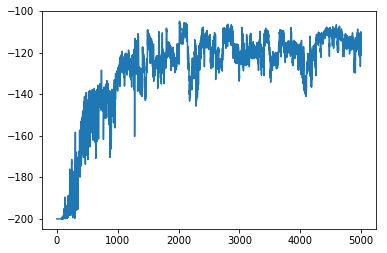

In [139]:
average_score = gym_agent1.run(500000, mode='train')       
plt.plot(average_score)

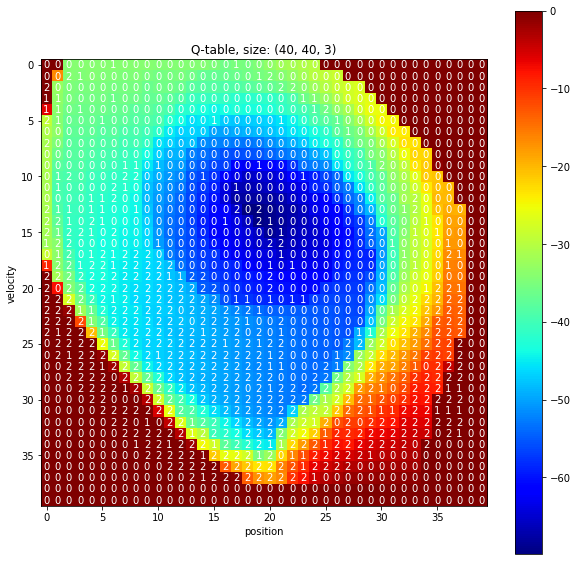

In [140]:
plot_q_table(gym_agent1.Q)

In [143]:
gym_agent1.run(20, mode='test')

Episode 0/20. Avg score: -145.0. eps: 0.01. Delta average: 0.0470020720483074   

[-145.0]

In [144]:
np.save('gym_mountainCarQ-40-40', gym_agent1.Q, allow_pickle=True, fix_imports=True)